In [22]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import TransformedTargetRegressor
from sklearn.feature_selection import (
    RFE,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    VarianceThreshold,
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR

from sklearn_helpers import (
    ResultContainer,
    fit_models,
    get_column_transformer,
    get_models,
    get_preprocessor,
    show_coefficients,
)

simplefilter(action="ignore", category=FutureWarning)
pd.set_option("precision", 3)
pd.set_option("display.max_columns", 100)
sns.set_theme(style="whitegrid")

In [3]:
listings_extended = pd.read_pickle("../data-clean/listings_extended.pkl")
X = listings_extended.drop(columns="price")
y = listings_extended["price"]

X.shape

(2601, 39)

In [54]:
listings_subset = pd.read_pickle("../data-clean/listings_subset.pkl")
X_subset = listings_extended.drop(columns="price")
y_subset = listings_extended["price"]

X_subset = column_transformer.fit_transform(X_subset)
X_subset.shape

(2601, 79)

In [35]:
# Overall settings for feature selection
column_transformer = get_column_transformer()
num_features = 25

In [36]:
# SUBSECTION: RFE feature selection
# Recursive feature elimination based on importance weights.
rfe = RFE(SVR(kernel="linear"), n_features_to_select=num_features, step=0.5)
preprocessor = get_preprocessor(column_transformer, rfe)
model = LinearRegression()

pipeline = make_pipeline(preprocessor, model)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X, y)
coefs = show_coefficients(log_transform)
coefs

,feature,coefficient
0,neighbourhood_Sentrum,0.291
1,neighbourhood_Frogner,0.259
2,neighbourhood_St. Hanshaugen,0.223
3,property_type_Entire villa,0.213
4,room_type_Entire home/apt,0.208
5,availability_30,0.208
6,neighbourhood_Grünerløkka,0.172
7,bedrooms,0.162
8,accommodates,0.145
9,neighbourhood_Gamle Oslo,0.134


In [37]:
# filter coefficients close to zero: too small impact to add to analysis
coefs[abs(coefs["coefficient"]) < 0.1]

,feature,coefficient
12,availability_90,0.086
13,maximum_minimum_nights,0.076
14,neighbourhood_Ullern,0.072
15,property_type_Private room in residential home,-0.095
16,availability_60,-0.096


In [38]:
important_coefs_rfe = coefs[abs(coefs["coefficient"]) > 0.1]
print(f"Number of coefficients with absolute value greater than 0.1: \n {len(important_coefs)}")

important_coefs


Number of coefficients with absolute value greater than 0.1: 
 20


,feature,coefficient
0,maximum_nights_avg_ntm,0.393
1,property_type_Entire villa,0.280
2,neighbourhood_Frogner,0.279
3,neighbourhood_Sentrum,0.271
4,neighbourhood_St. Hanshaugen,0.226
5,availability_30,0.175
6,accommodates,0.174
7,bedrooms,0.172
8,neighbourhood_Grünerløkka,0.159
9,property_type_Entire serviced apartment,0.159


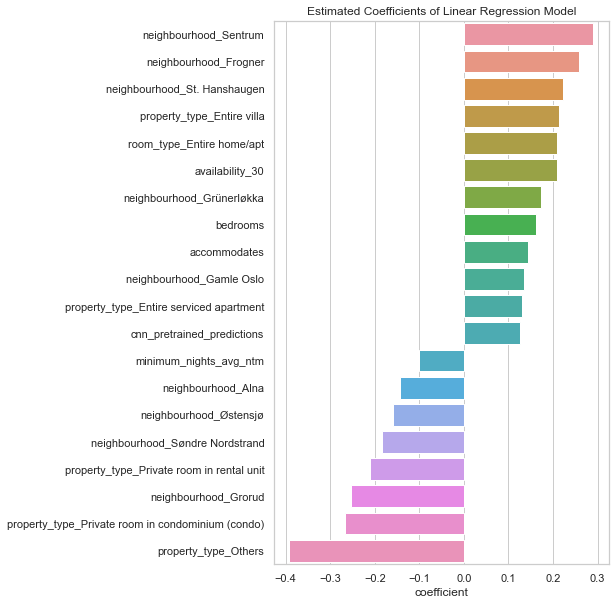

In [39]:
fig, ax = plt.subplots(nrows=1, figsize=(6, 10))

sns.barplot(data=important_coefs_rfe, x="coefficient", y="feature", ax=ax).set(
    title="Estimated Coefficients of Linear Regression Model", ylabel=""
)

plt.show()

Result: All 20 features selected by RFE are already part of our feature_subset data frame!

In [40]:
# SUBSECTION: SelectFromModel
sfm = SelectFromModel(SVR(kernel="linear"), threshold="1.5*mean")
preprocessor = get_preprocessor(column_transformer, sfm)
model = LinearRegression()

pipeline = make_pipeline(preprocessor, model)
log_transform = TransformedTargetRegressor(pipeline, func=np.log, inverse_func=np.exp)

log_transform.fit(X, y)
coefs = show_coefficients(log_transform)
coefs

,feature,coefficient
0,maximum_nights_avg_ntm,0.393
1,property_type_Entire villa,0.280
2,neighbourhood_Frogner,0.279
3,neighbourhood_Sentrum,0.271
4,neighbourhood_St. Hanshaugen,0.226
5,availability_30,0.175
6,accommodates,0.174
7,bedrooms,0.172
8,neighbourhood_Grünerløkka,0.159
9,property_type_Entire serviced apartment,0.159


Number of coefficients with absolute value greater than 0.1: 
 20


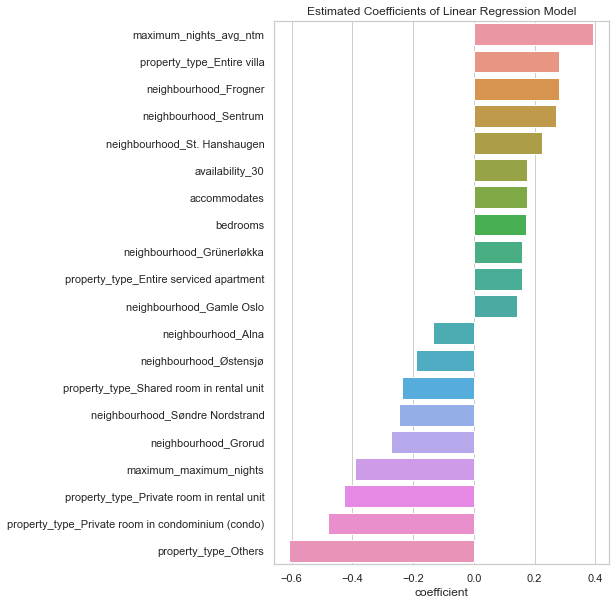

In [41]:
important_coefs_sfm = coefs[abs(coefs["coefficient"]) > 0.1]
print(f"Number of coefficients with absolute value greater than 0.1: \n {len(important_coefs)}")

fig, ax = plt.subplots(nrows=1, figsize=(6, 10))

sns.barplot(data=important_coefs_sfm, x="coefficient", y="feature", ax=ax).set(
    title="Estimated Coefficients of Linear Regression Model", ylabel=""
)

plt.show()

In [49]:
diff = np.sort(important_coefs_rfe["feature"]) != np.sort(important_coefs_sfm["feature"])
important_coefs_rfe[diff]

,feature,coefficient
3,property_type_Entire villa,0.213
4,room_type_Entire home/apt,0.208
24,property_type_Others,-0.392


In [ ]:
HistGradientBoostingRegressor